In [67]:
## Loading Libraries
suppressMessages(library(dplyr))
library("IRdisplay") # Display plots in jupyter notebook
# Differential gene expression analysis
suppressMessages(library("edgeR"))
# Enrichment Analysis. KEGG pathways
suppressMessages(library("AnnotationDbi")) # To map Entrez gene IDs in order to find KEGG pathways
library("org.Hs.eg.db") # Homo sapiens AnnotationDbi database package
suppressMessages(library(pathview)) # Draws  pathway diagrams
library(gage) # Pathway analysis
library(gageData)
data(kegg.sets.hs) # contains member gene Entrez IDs for KEGG pathways
data(sigmet.idx.hs) # gives a cleaner gene sets of signaling and metabolic pathways only
setwd('~/Documents/experiment/')

In [68]:
# Loading counts and metadata tables
countsData <- read.table('output/featureCounts/merged_gene_counts.txt', sep = '\t', row.names = 1, header = T) # counts table of two samples from different cell lines
metaData <- read.table('SraRunTable.txt', header = T, sep = ',') # Metadata table of samples
head(countsData)
metaData

,gene_name,SRR925742_1,SRR1283038_1
,<chr>,<int>,<int>
ENSG00000223972.5,DDX11L1,0,2
ENSG00000227232.5,WASH7P,9,25
ENSG00000278267.1,MIR6859-1,0,0
ENSG00000243485.5,MIR1302-2HG,0,0
ENSG00000284332.1,MIR1302-2,0,0
ENSG00000237613.2,FAM138A,0,0


Run,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Cell_Line,Cell_type,Center.Name,⋯,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,Sample.Name,source_name,SRA.Study,subtype,quality..run.
<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
SRR925742,RNA-Seq,152,4253695832,PRJNA210428,SAMN02225564,2139823332,ZR75B,breast cancer,GEO,⋯,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2015-07-22T00:00:00Z,GSM1172910,breast cancer cell line,SRP026537,Luminal,NA
SRR1283038,RNA-Seq,154,6907369604,PRJNA210428,SAMN02768721,3756629102,MDAMB453,breast cancer cell line,GEO,⋯,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2014-05-12T00:00:00Z,GSM1384316,breast cancer cell line,SRP026537,Luminal,NA


In [69]:
# Preprocessing
colnames(countsData)[c(2,3)] <- gsub("_1", "", colnames(countsData)[c(2,3)]) # Gene name formatting: removing sufix _1 from sample names
names(countsData)
cellLine <- as.factor(metaData$Cell_Line) # groups to be compared: 2 different cell lines 
names(cellLine) <- metaData$Run
geneName <- countsData$gene_name
countsData$gene_name <- NULL # countsData only with counts columns of each sample

[1] "gene_name"  "SRR925742"  "SRR1283038"

In [70]:
# Differential expression functions
dgeList <-DGEList(counts = countsData, group = cellLine, genes = geneName) 
sapply(dgeList, dim) # Number of genes before filtering

counts,samples,genes
29985,2,29985
2,3,1


In [71]:
# Filtering out genes with low amount of counts
toKeep <- filterByExpr(dgeList)
dgeListFilt <- dgeList[toKeep, , keep.lib.sizes=FALSE]
sapply(dgeListFilt, dim) # Number of genes after filtering

counts,samples,genes
1079,2,1079
2,3,1


In [72]:
# Data Normalization. by default with TMM method
dgeListNorm <- calcNormFactors(dgeListFilt) 
sapply(dgeListNorm, head)
dgeListNorm <- estimateCommonDisp(dgeListNorm)
dgeListNorm$common.dispersion <- 0.1 # Dispersion is setting manually due to the lack of replicates. Is needed for computing foldchange

$counts
                  SRR925742 SRR1283038
ENSG00000227232.5         9         25
ENSG00000279457.4        19         35
ENSG00000225972.1      1028        192
ENSG00000225630.1      3497       1018
ENSG00000237973.1     12303      12954
ENSG00000229344.1      4057       3849

$samples
              group lib.size norm.factors
SRR925742     ZR75B    93866    0.8958021
SRR1283038 MDAMB453    99903    1.1163180

$genes
                     genes
ENSG00000227232.5   WASH7P
ENSG00000279457.4   WASH9P
ENSG00000225972.1 MTND1P23
ENSG00000225630.1 MTND2P28
ENSG00000237973.1 MTCO1P12
ENSG00000229344.1 MTCO2P12

Warning message in estimateCommonDisp.DGEList(dgeListNorm):
“There is no replication, setting dispersion to NA.”


In [73]:
# Computing fold change 
dgeListFC <- exactTest(dgeListNorm) # this method allows performing fold change when only two groups are compared
# Top differential expressed genes
(topDEG <- topTags(dgeListFC))

,genes,logFC,logCPM,PValue,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000137975.8,CLCA2,-9.524991,12.256025,6.785266e-17,7.321302e-14
ENSG00000185499.16,MUC1,9.146239,11.508080,1.792863e-15,9.672495e-13
ENSG00000117519.16,CNN3,-10.612446,10.012702,4.322283e-12,1.554581e-09
ENSG00000162383.13,SLC1A7,-10.404146,9.811095,1.637838e-11,4.418067e-09
ENSG00000188460.4,ACTBP11,6.240111,9.536169,8.449521e-10,1.823407e-07
ENSG00000178715.8,AL450998.1,5.577043,9.438242,9.239616e-09,1.661591e-06
ENSG00000230364.1,RPL4P3,5.122906,9.702888,2.223249e-08,3.426979e-06
ENSG00000225616.2,AL138785.1,9.053653,8.444698,6.691571e-08,8.379931e-06
ENSG00000230777.1,RPS29P5,5.232967,9.107470,6.989748e-08,8.379931e-06


In [74]:
# Data processing for enrichment analysis
dfTest <- dgeListFC$table[order(dgeListFC$table$PValue),] # Ordering by Pvalue
summary(dfTest)
# Ensembl gene IDs formating
row.names(dfTest) <- gsub("\\.[0-9]*$", "", row.names(dfTest)) # Number after period corresponds to chr version 
head(row.names(dfTest))

     logFC               logCPM           PValue       
 Min.   :-10.61245   Min.   : 6.545   Min.   :0.00000  
 1st Qu.: -0.80670   1st Qu.: 7.612   1st Qu.:0.07568  
 Median :  0.01006   Median : 8.527   Median :0.31982  
 Mean   :  0.14664   Mean   : 8.703   Mean   :0.38528  
 3rd Qu.:  0.83709   3rd Qu.: 9.513   3rd Qu.:0.64924  
 Max.   :  9.14624   Max.   :17.002   Max.   :1.00000  

[1] "ENSG00000137975" "ENSG00000185499" "ENSG00000117519" "ENSG00000162383"
[5] "ENSG00000188460" "ENSG00000178715"

In [75]:
# Maping Symbol, entrez ID and gene name to obtain KEGG pathways
dfTest$symbol <- mapIds(org.Hs.eg.db, keys = row.names(dfTest), column="SYMBOL", keytype="ENSEMBL", multiVals = "first") # setting multivals="first" in case there were multiple possible values for a single input
dfTest$entrez <- mapIds(org.Hs.eg.db, keys = row.names(dfTest), column="ENTREZID", keytype="ENSEMBL", multiVals = "first") # setting multivals in case there were multiple possible values for a single input
dfTest$name <- mapIds(org.Hs.eg.db, keys = row.names(dfTest), column="GENENAME", keytype="ENSEMBL", multiVals = "first") # setting multivals in case there were multiple possible values for a single input
head(dfTest)

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



,logFC,logCPM,PValue,symbol,entrez,name
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
ENSG00000137975,-9.524991,12.256025,6.785266e-17,CLCA2,9635,chloride channel accessory 2
ENSG00000185499,9.146239,11.508080,1.792863e-15,MUC1,4582,"mucin 1, cell surface associated"
ENSG00000117519,-10.612446,10.012702,4.322283e-12,CNN3,1266,calponin 3
ENSG00000162383,-10.404146,9.811095,1.637838e-11,SLC1A7,6512,solute carrier family 1 member 7
ENSG00000188460,6.240111,9.536169,8.449521e-10,NA,NA,NA
ENSG00000178715,5.577043,9.438242,9.239616e-09,NA,NA,NA


In [76]:
# Gene sets of signaling and metabolic pathways
kegg.sets.hs <- kegg.sets.hs[sigmet.idx.hs] 

foldchanges <- dfTest$logFC
names(foldchanges) <- dfTest$entrez # Entrez gene IDs are required to use gage() function
head(foldchanges)
keggres <- gage(foldchanges, gsets=kegg.sets.hs, same.dir=T) # same.dir=T gives a separate lists for pathways upregulated vs downregulated
lapply(keggres, head)

9635       4582       1266       6512       <NA>       <NA> 
 -9.524991   9.146239 -10.612446 -10.404146   6.240111   5.577043

,p.geomean,stat.mean,p.val,q.val,set.size,exp1
hsa04146 Peroxisome,0.4015129,0.2546759,0.4015129,0.9284442,10,0.4015129
hsa04141 Protein processing in endoplasmic reticulum,0.5755876,-0.1938308,0.5755876,0.9284442,10,0.5755876
hsa03013 RNA transport,0.5767711,-0.1986900,0.5767711,0.9284442,10,0.5767711
hsa04062 Chemokine signaling pathway,0.6288352,-0.3330276,0.6288352,0.9284442,13,0.6288352
hsa04722 Neurotrophin signaling pathway,0.6334105,-0.3457895,0.6334105,0.9284442,11,0.6334105
hsa04510 Focal adhesion,0.6856722,-0.4929917,0.6856722,0.9284442,11,0.6856722
,p.geomean,stat.mean,p.val,q.val,set.size,exp1
hsa04810 Regulation of actin cytoskeleton,0.07155577,-1.5240189,0.07155577,0.4668536,12,0.07155577
hsa04530 Tight junction,0.14345639,-1.0931664,0.14345639,0.4668536,12,0.14345639
hsa04010 MAPK signaling pathway,0.19436083,-0.8787869,0.19436083,0.4668536,13,0.19436083


In [77]:
# Getting the KEEG pathways
keggrespathways <- data.frame(id=rownames(keggres$greater), keggres$greater) %>% 
tibble::as_tibble() %>% 
filter(row_number()<=5) %>% 
.$id %>% 
as.character()

keggrespathways # KEEG ids formating
keggresids <- substr(keggrespathways, start=1, stop=8)
keggresids

[1] "hsa04146 Peroxisome"                                 
[2] "hsa04141 Protein processing in endoplasmic reticulum"
[3] "hsa03013 RNA transport"                              
[4] "hsa04062 Chemokine signaling pathway"                
[5] "hsa04722 Neurotrophin signaling pathway"

[1] "hsa04146" "hsa04141" "hsa03013" "hsa04062" "hsa04722"

'select()' returned 1:1 mapping between keys and columns

Info: Working in directory /Users/felipe/Documents/experiment

Info: Writing image file hsa04146.pathview.png

'select()' returned 1:1 mapping between keys and columns

Info: Working in directory /Users/felipe/Documents/experiment

Info: Writing image file hsa04141.pathview.png

'select()' returned 1:1 mapping between keys and columns

Info: Working in directory /Users/felipe/Documents/experiment

Info: Writing image file hsa03013.pathview.png

'select()' returned 1:1 mapping between keys and columns

Info: Working in directory /Users/felipe/Documents/experiment

Info: Writing image file hsa04062.pathview.png

'select()' returned 1:1 mapping between keys and columns

Info: Working in directory /Users/felipe/Documents/experiment

Info: Writing image file hsa04722.pathview.png



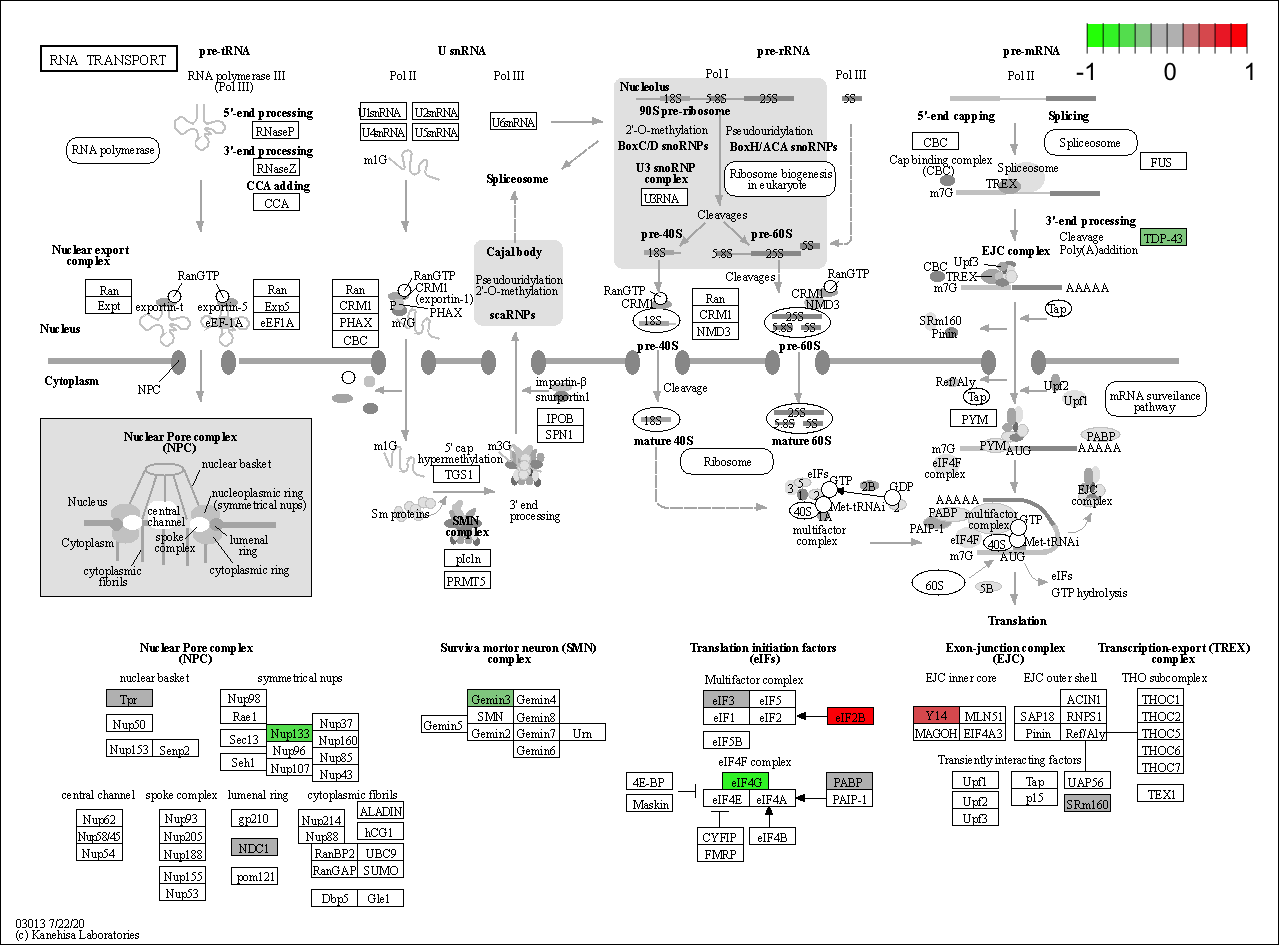

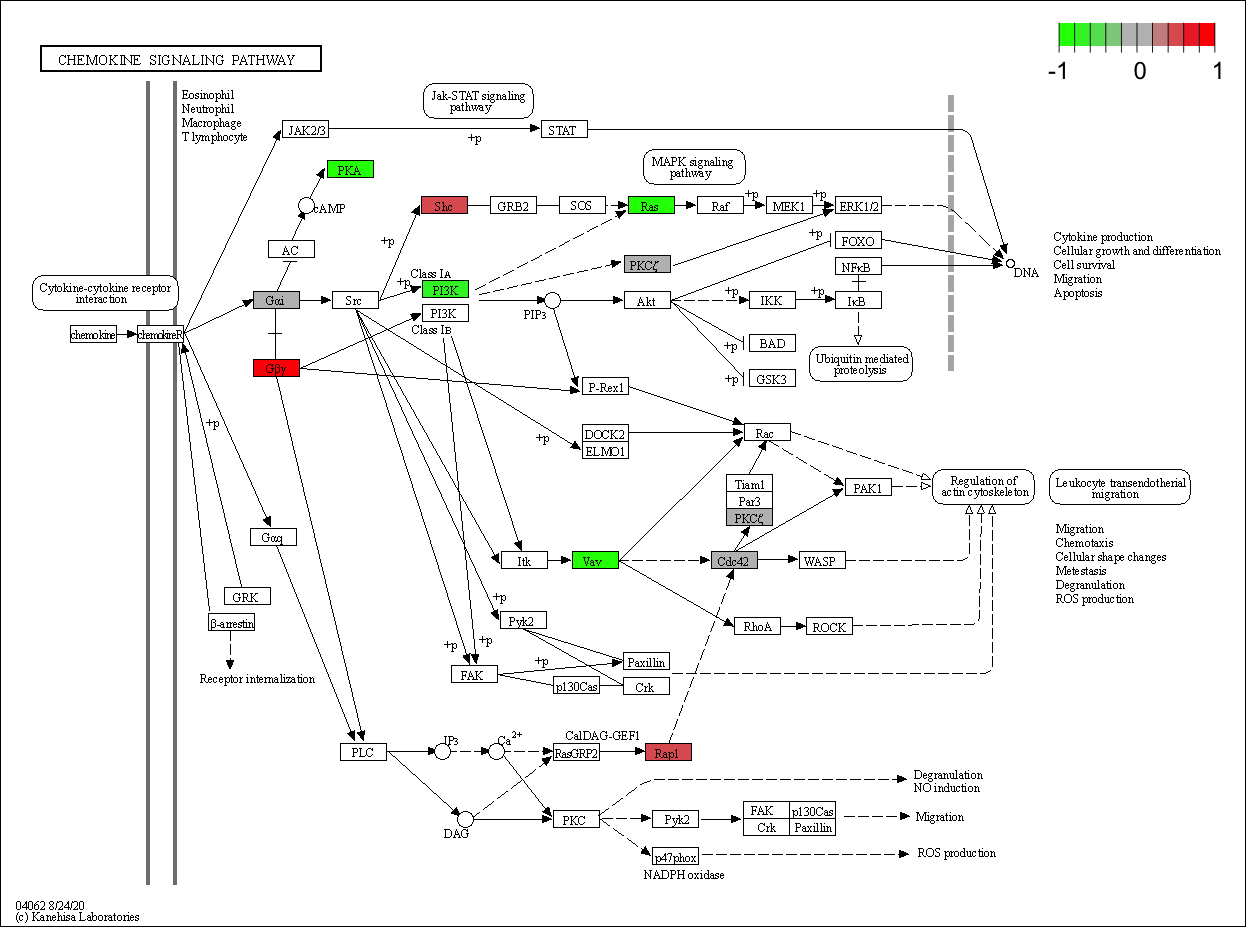

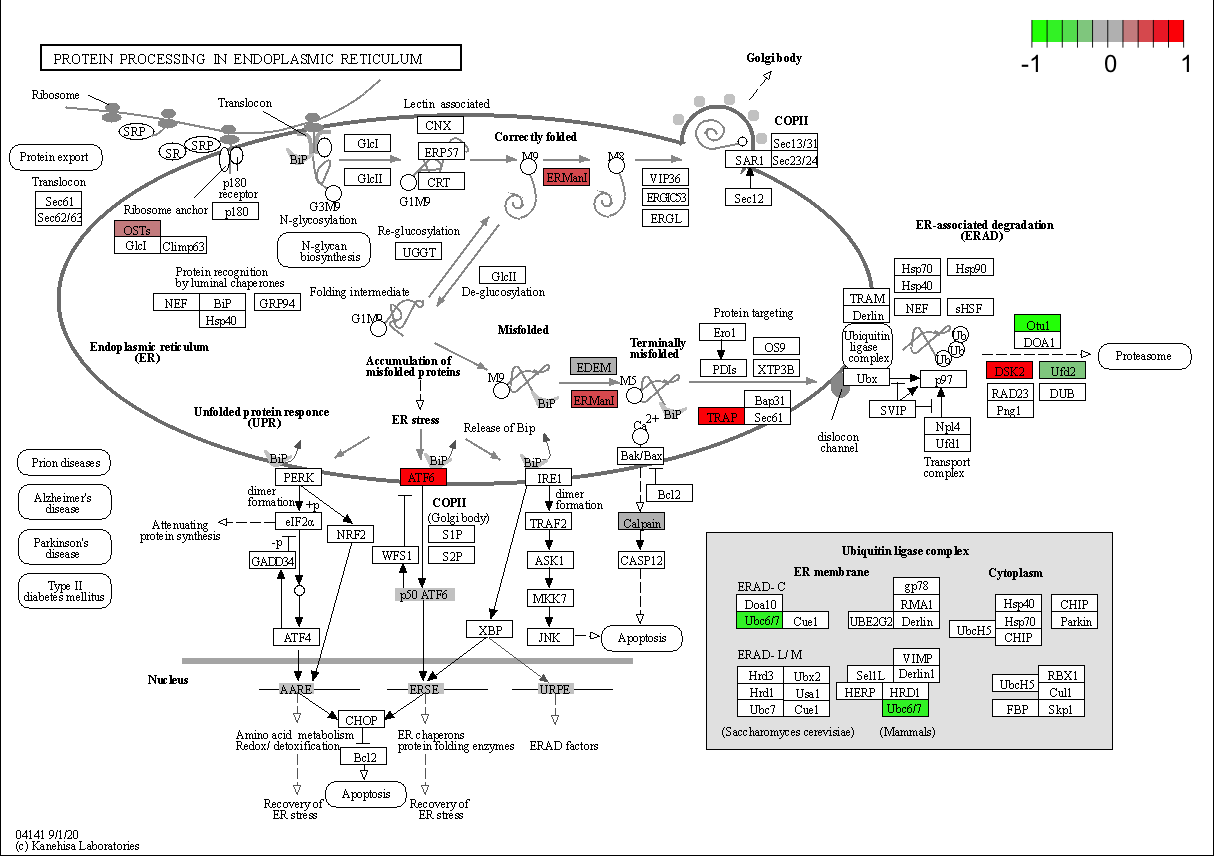

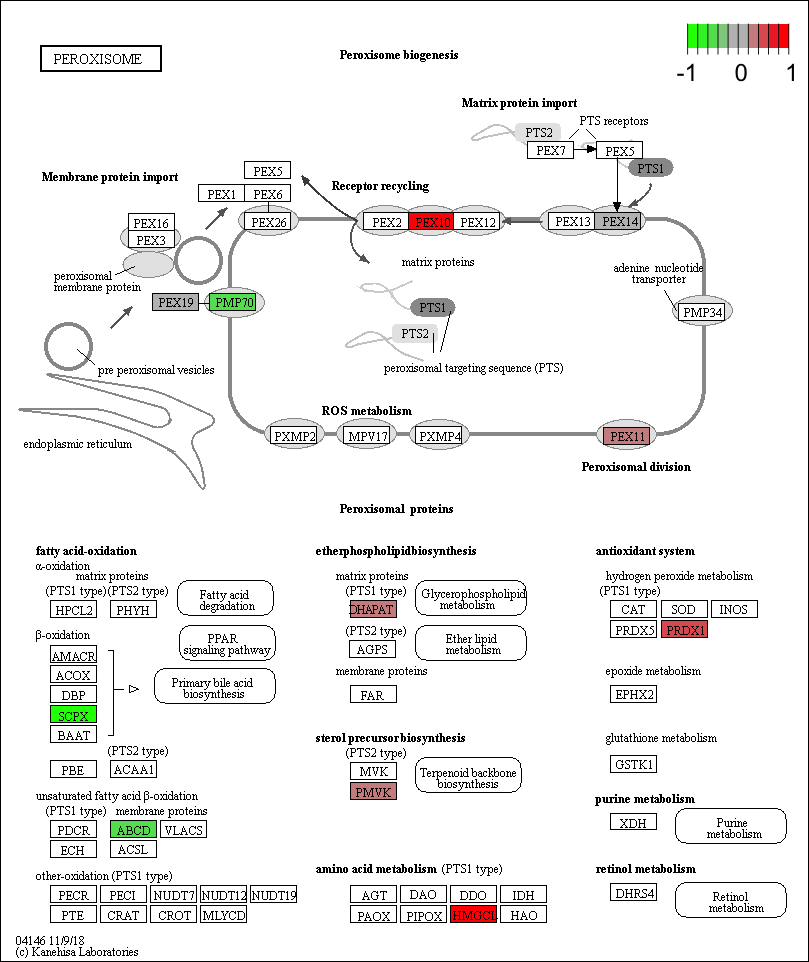

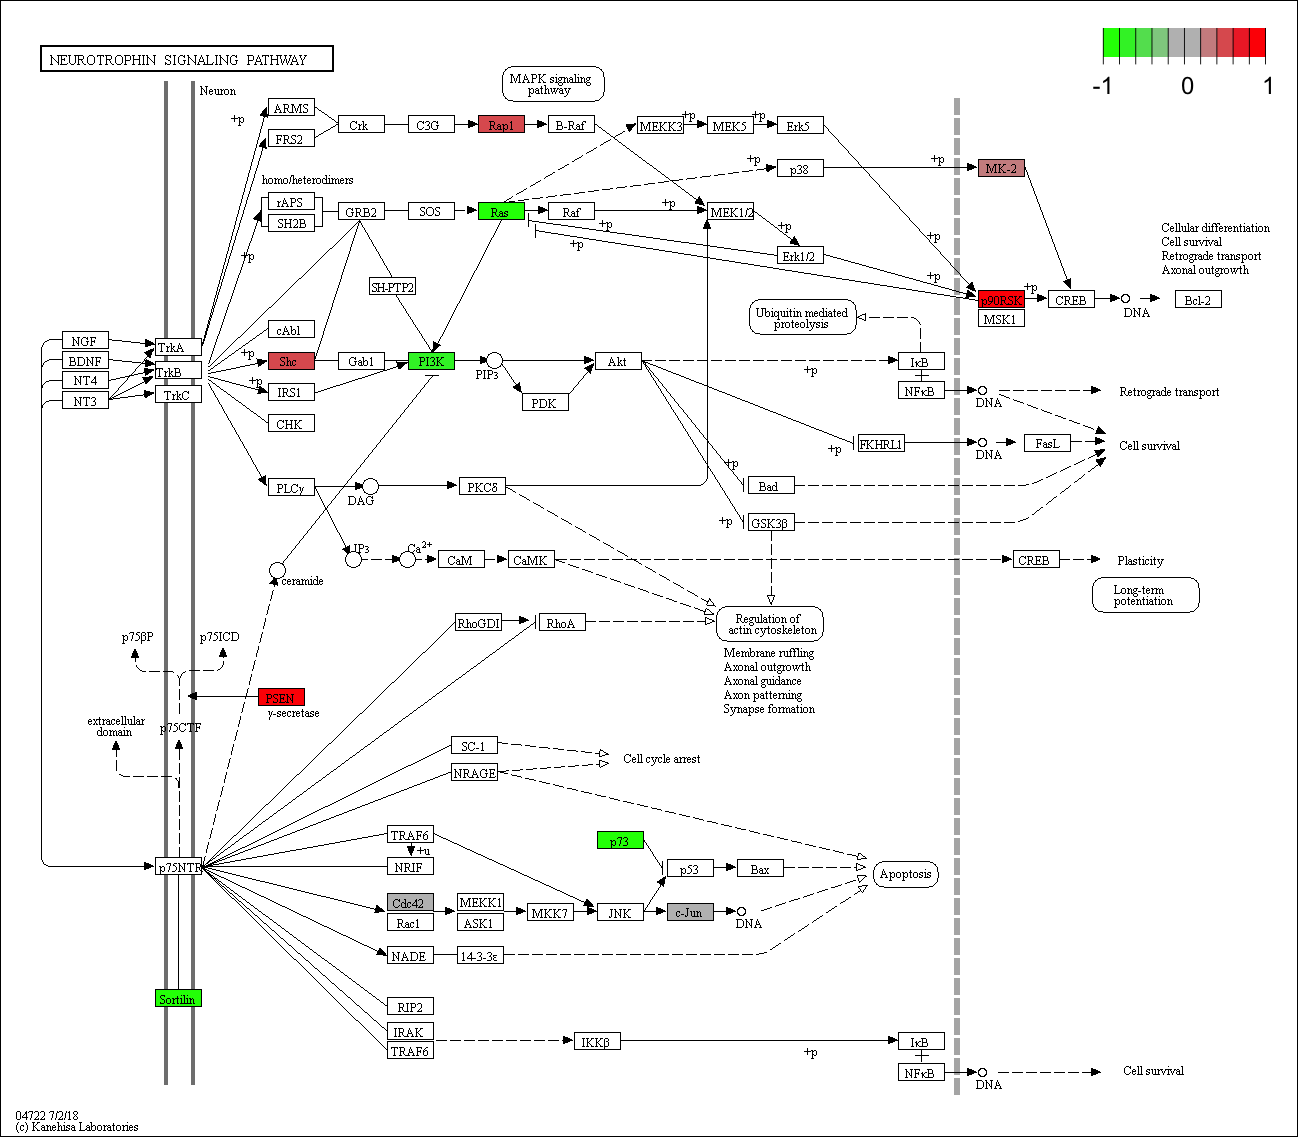

In [78]:
# plo
plot_pathway <- function(pid) pathview(gene.data=foldchanges, pathway.id=pid, species="hsa", new.signature=FALSE) # Plotting function
# plot multiple pathways (plots saved to disk and returns a throwaway list object)
tmp <- sapply(keggresids, plot_pathway)
tmpPlots <- list.files(pattern="*.pathview.png")
for (i in tmpPlots){
    display_png(file=i, width = 1000, height = 1000)
}